# Seção 05.04 - Boosting (base crédito)
Para esta seção, usarei a base de dados "credit-data.csv" disponibilizada no curso do Professor Jones na UDEMY.
A parte teórica vem das aulas do prof. Eduardo Vargas Ferreira (LEG-UFPR)

## Boosting
Antes vamos lembrar a importância dos resíduos. Segundo o prof. Eduardo Vargas Ferreira (LEG-UFPR), "nos resíduos está 'tudo' que o modelo não conseguiu captar". Numa regressão temos:
<tr>
    <td>
        <img src="../imagens/boosting_residuos.png" alt="Relação entre a regressão e os resíduos." width="350"/>
        <p style="text-align:center">Figura 01 - Relação entre a regressão e os resíduos.</p>
        <p style="text-align:center">Fonte: <a href="http://cursos.leg.ufpr.br/ML4all/1parte/">Aulas do Prof. Eduardo Vargas Ferreira (LEG-UFPR)</a>.</p>
    </td>
</tr>

A Figura 01 mostra a relação entre o erro total (**SQT**), o valor estimado pela regressão (**SQR**) e o resíduo (**SQE**). Ou seja, toda variabilidade **NÃO explicada** pela regressão ficará no resíduo.

### 1. O que é?
Modelos de aprendizado em conjunto (ensemble) do tipo boosting são construídos colocando estimadores em sequência, onde um estimador tenta reduzir o viés do conjunto anterior a ele. Ainda segundo a [documentação do do Sci-kit learn](https://scikit-learn.org/stable/modules/ensemble.html#ensemble), a motivação é combinar modelos fracos para produzir um conjunto (ensemble) poderoso.

Boosting é classificado como um tipo de aprendizado em conjunto ou *Ensemble*. Existem três tipos de *Ensemble* que são o Bagging, o Boosting e, por fim, o Stacking.


Fonte: [Breiman, 1994 - Bagging Predictors](https://www.stat.berkeley.edu/~breiman/bagging.pdf)


## Exemplos de métodos de boosting
### 1. AdaBoost / Adaptive Boosting (1995)
- proposto por Freund, Y. e Schapire, R.

### 2. Gradient Tree Boosting / Gradient Boosting Machine (GBM) (Fevereiro de 1999)
- proposto por Friedman, J. H.

### 3. XGBoost (Março de 2014)
- proposto por Tianqi Chen.

### 4. Light GBM (Janeiro de 2017)
- proposto por Microsoft.

### 5. CatBoost (Abril de 2017)
- proposto por Yandex (comentário de Suto: "Yandex é o Google Russo").

<tr>
    <td>
        <img src="../imagens/boosting_cat_XGB_LightGBM.PNG" alt="CatBoost vs. Light GBM vs. XGBoost. Cronologia." width="580"/>
        <p style="text-align:center">Figura 01 - CatBoost vs. Light GBM vs. XGBoost. Cronologia.</p>
        <p style="text-align:center">Fonte: <a href="https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db">2018 - Swalin, A.; "CatBoost vs. Light GBM vs. XGBoost; texto no Medium"</a>.</p>
    </td>
</tr>

In [1]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Lidar com validação de modelos.
from sklearn.metrics import (confusion_matrix
                             , accuracy_score
                             , classification_report)

from sklearn.model_selection import (train_test_split
                                     , cross_val_score
                                     , StratifiedKFold)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
nomeDaBase = "../../bases/credit-data.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

df.head().T

,0,1,2,3,4
clientid,1.000000,2.000000,3.000000,4.000000,5.000000
income,66155.925095,34415.153966,57317.170063,42709.534201,66952.688845
age,59.017015,48.117153,63.108049,45.751972,18.584336
loan,8106.532131,6564.745018,8020.953296,6103.642260,8770.099235
default,0.000000,0.000000,0.000000,0.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
clientid    2000 non-null int64
income      2000 non-null float64
age         1997 non-null float64
loan        2000 non-null float64
default     2000 non-null int64
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clientid,2000.0,1000.500000,577.494589,1.00000,500.750000,1000.500000,1500.250000,2000.000000
income,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
default,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


### Problemas encontrados na base:
1. Em "age", há 3 valores nulos e há a presença de valores negativos.

#### OBSERVAÇÃO:

No mundo real, os problemas com as bases são muito piores. Deve-se ter muita atenção pois os dados podem não representar a realidade do processo.

In [5]:
df.loc[df.age < 0, "age"] = df.age.mean()

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(df)

df_tratado = pd.DataFrame(data=imputer.transform(df), columns=df.columns)
df_tratado.set_index("clientid", inplace=True)

## 1) Aplicação da Aprendizagem por random forests

### 1.1) Usando *train_test_split*  

In [7]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:-1]
y = df_tratado.iloc[:, -1]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Testando com diferentes modelos de aprendizado em conjunto:

### 1. AdaBoost / Adaptive Boosting (1995)

In [9]:
from sklearn.ensemble import AdaBoostClassifier

classificador_adaboost = AdaBoostClassifier(n_estimators=40
                                            , random_state=0)

classificador_adaboost.fit(x_train
                           , y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=40, random_state=0)

#### A importância de cada fator / variável independente na resposta / variável dependente:

In [10]:
lista_fatores = list(df_tratado.drop("default", axis=1).columns)

pd.DataFrame(classificador_adaboost.feature_importances_.reshape(1,-1), columns=lista_fatores)

,income,age,loan
0,0.475,0.05,0.475


#### Verificando o como o modelo se saiu:

In [11]:
y_pred_adaboost = classificador_adaboost.predict(x_test)

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred_adaboost, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred_adaboost)))

Métrica 1 (Acurácia): 0.9825.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       348
         1.0       0.94      0.92      0.93        52

    accuracy                           0.98       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.98      0.98      0.98       400
.


### 2. Gradient Tree Boosting / Gradient Boosting Machine (GBM) (Fevereiro de 1999)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

classificador_gbm = GradientBoostingClassifier(n_estimators=40
                                                    , random_state=0)

classificador_gbm.fit(x_train
                      , y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=40,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### A importância de cada fator / variável independente na resposta / variável dependente:

In [13]:
lista_fatores = list(df_tratado.drop("default", axis=1).columns)

pd.DataFrame(classificador_gbm.feature_importances_.reshape(1,-1), columns=lista_fatores)

,income,age,loan
0,0.175621,0.356719,0.46766


#### Verificando o como o modelo se saiu:

In [14]:
y_pred_gbm = classificador_gbm.predict(x_test)

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred_gbm, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred_gbm)))

Métrica 1 (Acurácia): 0.9825.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       348
         1.0       0.98      0.88      0.93        52

    accuracy                           0.98       400
   macro avg       0.98      0.94      0.96       400
weighted avg       0.98      0.98      0.98       400
.


### 3. XGBoost (Março de 2014)

### 4. Light GBM (Janeiro de 2017)

### 5. CatBoost (Abril de 2017)

### Por fim, comparando com Random Forest:

In [15]:
from sklearn.ensemble import RandomForestClassifier

classificador = RandomForestClassifier(n_estimators=40
                                       , criterion='entropy'
                                       , random_state=0)

classificador.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### A importância de cada fator / variável independente na resposta / variável dependente:

In [16]:
lista_fatores = list(df_tratado.drop("default", axis=1).columns)

pd.DataFrame(classificador.feature_importances_.reshape(1,-1), columns=lista_fatores)

,income,age,loan
0,0.138052,0.471457,0.39049


In [17]:
y_pred = classificador.predict(x_test)

#### Verificando o como o modelo se saiu:

In [18]:
print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred)))

Métrica 1 (Acurácia): 0.9825.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       348
         1.0       0.94      0.92      0.93        52

    accuracy                           0.98       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.98      0.98      0.98       400
.


Normalized confusion matrix
[[0.99137931 0.00862069]
 [0.07692308 0.92307692]]


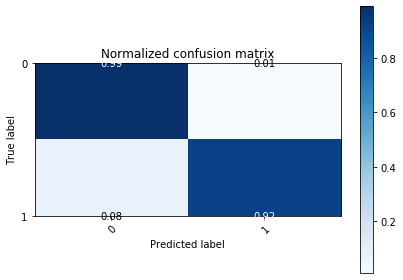

In [19]:
plot_confusion_matrix_2(y_test, y_pred, normalize=True);

### Agora, usando validação cruzada.

In [20]:
classificador = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state=0, max_depth=3)
classificador.fit(x, y)

resultados = cross_val_score(classificador, x, y, cv = 10)

classe = y.values

print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

Acurácia média: 0.921 ± 0.0129.
